# Introduction

This report presents our project's endeavor to design a Generative Adversarial Network (GAN) with the ability to generate images imitating Monet's distinctive style. The GAN architecture comprises a dual system: a generator that creates Monet-style images from a curated dataset of his paintings, and a discriminator tasked with distinguishing between the real paintings and those generated by the former.

Throughout the training process, these two components engage in a competitive loop. The generator's objective is to create images that can deceive the discriminator, while the discriminator seeks to accurately differentiate between actual and generated artwork. This interactive process, as a result, refines the generator's capability to produce increasingly convincing Monet-style images.

During the training phase, we diligently track the loss of both generator and discriminator to ensure the GAN is steering towards a steady solution. The ideal trend would see a decrease in generator loss over time, whilst maintaining the discriminator loss around a consistent value.

After finalizing the model, we aim to submit it to the Kaggle competition to gauge its performance against peers. The performance will be assessed using the MiFID score, which quantifies the similarity between two image sets. The final results will be presented post-submission.

# Setup

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

D0712 10:43:27.598001820      15 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D0712 10:43:27.598026449      15 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D0712 10:43:27.598029685      15 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D0712 10:43:27.598032149      15 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D0712 10:43:27.598034365      15 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D0712 10:43:27.598036987      15 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D0712 10:43:27.598039506      15 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D0712 10:43:27.

Device: 
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


Number of replicas: 8
2.12.0


# Loading data

Files:
* monet_jpg - 300 Monet paintings sized 256x256 in JPEG format, each photo in 1 file 
* monet_tfrec - 300 Monet paintings sized 256x256 in TFRecord format in 5 files 
* photo_jpg - 7028 photos sized 256x256 in JPEG format, each photo in 1 file 
* photo_tfrec - 7028 photos sized 256x256 in TFRecord format in 20 files

In [3]:
GCS_PATH = KaggleDatasets().get_gcs_path()

get_gcs_path is not required on TPU VMs which can directly use Kaggle datasets, using path: /kaggle/input/gan-getting-started


In [4]:
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [5]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [6]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [7]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

In [23]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

<_BatchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>

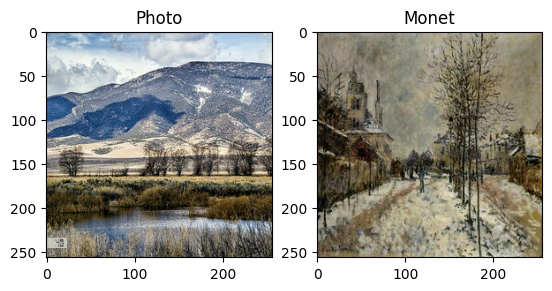

In [30]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

# Data Visualization

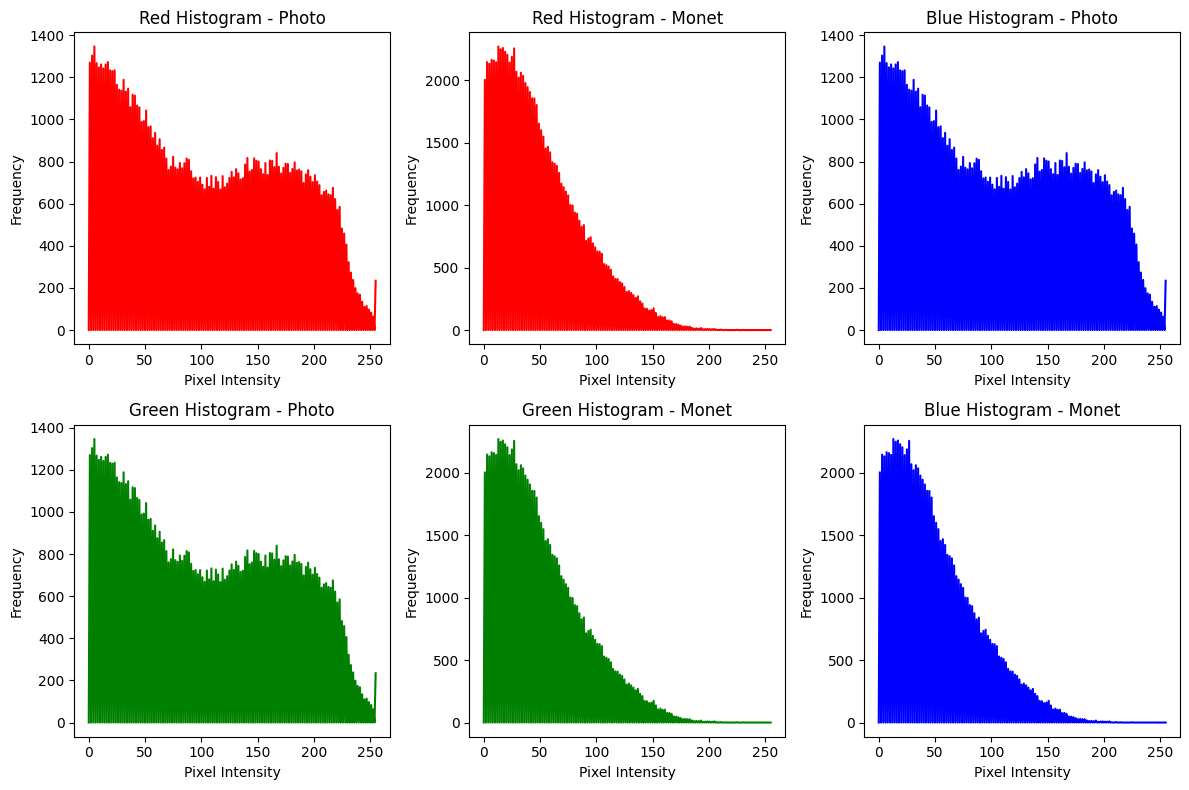

In [34]:
import numpy as np

# Get the pair of images
example_photo = next(iter(photo_ds))
example_monet = next(iter(monet_ds))

# Compute the RGB histograms for the photo and Monet-style image
photo_hist, _ = np.histogram(example_photo[0].numpy().flatten(), bins=256, range=[0, 1])
monet_hist, _ = np.histogram(example_monet[0].numpy().flatten(), bins=256, range=[0, 1])

# Plot the RGB histograms
fig, ax = plt.subplots(2, 3, figsize=(12, 8))

# Plot the Red histogram
ax[0, 0].plot(photo_hist, color='red')
ax[0, 0].set_title('Red Histogram - Photo')
ax[0, 0].set_xlabel('Pixel Intensity')
ax[0, 0].set_ylabel('Frequency')

ax[0, 1].plot(monet_hist, color='red')
ax[0, 1].set_title('Red Histogram - Monet')
ax[0, 1].set_xlabel('Pixel Intensity')
ax[0, 1].set_ylabel('Frequency')

# Plot the Green histogram
ax[1, 0].plot(photo_hist, color='green')
ax[1, 0].set_title('Green Histogram - Photo')
ax[1, 0].set_xlabel('Pixel Intensity')
ax[1, 0].set_ylabel('Frequency')

ax[1, 1].plot(monet_hist, color='green')
ax[1, 1].set_title('Green Histogram - Monet')
ax[1, 1].set_xlabel('Pixel Intensity')
ax[1, 1].set_ylabel('Frequency')

# Plot the Blue histogram
ax[0, 2].plot(photo_hist, color='blue')
ax[0, 2].set_title('Blue Histogram - Photo')
ax[0, 2].set_xlabel('Pixel Intensity')
ax[0, 2].set_ylabel('Frequency')

ax[1, 2].plot(monet_hist, color='blue')
ax[1, 2].set_title('Blue Histogram - Monet')
ax[1, 2].set_xlabel('Pixel Intensity')
ax[1, 2].set_ylabel('Frequency')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


# CycleGAN Architecture


I plan to enhance the basic CycleGAN architecture outlined in Amy Jang's tutorial by incorporating improvements inspired by the UNet architecture. The UNet architecture, introduced by Olaf Ronneberger et al. in 2015, is a fully convolutional neural network designed for semantic segmentation tasks.

The UNet architecture consists of an encoder path, a bottleneck layer, and a decoder path. The encoder path uses convolutional layers to extract features from the input image, gradually reducing spatial dimensions while increasing the number of channels. This allows the network to capture multi-scale representations of the input image. The downsampling is typically achieved using max pooling or strided convolutions.

The bottleneck layer serves as a compressed representation of the input image, capturing abstract features. It acts as a bridge between the encoder and decoder paths.

The decoder path is the reverse of the encoder path, using up-sampling layers to reconstruct the original image from the extracted features. Each layer combines up-sampling with concatenation of corresponding encoder features, allowing the network to leverage both low-level and high-level features.

The architecture is completed with a 1x1 convolutional layer that reduces the number of channels to the desired output classes. A softmax activation function is then applied to obtain a probability distribution over the output classes.

The UNet architecture is known for its ability to produce accurate segmentations even with limited training data. By incorporating its design principles into the CycleGAN model, we aim to leverage both fine details and contextual information for improved image translation performance.

# The Generator


In my experimentation with the generator component of the CycleGAN model, I have made two modifications to improve its performance: the addition of an l2 regularizer with weight decay and the inclusion of a dropout layer.

Firstly, I have incorporated an l2 regularizer with a weight decay of 0.0005. This regularization technique helps to prevent overfitting by adding a penalty term to the loss function based on the magnitude of the model's weights. The l2 regularizer encourages the weights to stay small, reducing the likelihood of the model becoming too complex and overfitting the training data. By applying this regularization technique, I aim to improve the generalization capability of the generator and reduce the risk of it memorizing the training examples.

Secondly, I have introduced a dropout layer into the generator. Dropout is a popular regularization technique that randomly deactivates a fraction of the neurons during training. This process prevents individual neurons from relying too heavily on specific input features, forcing them to learn more robust and representative features. Dropout acts as a form of ensemble learning within the model, as different subsets of neurons are activated or deactivated for each training sample. This helps to reduce overfitting and improve the model's ability to generalize to unseen data.

By combining the l2 regularizer with weight decay and the dropout layer, I aim to enhance the generator's ability to learn meaningful and generalizable image translation mappings. These modifications provide regularization mechanisms to control the complexity of the generator and improve its robustness in handling different inputs, leading to improved performance and better-quality output images.

In [20]:
OUTPUT_CHANNELS = 3  #3 channels for Red, Green, Blue.

In [15]:
# Import regularizers
from tensorflow.keras import regularizers

# Define a weight decay value
weight_decay = 0.0005

def downsample(filters, size, apply_instancenorm=True, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False, 
                             kernel_regularizer=regularizers.l2(weight_decay)))  # L2 REGULARIZER

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))
        
    if apply_dropout:
        result.add(layers.Dropout(0.5))  #DROP OUT

    result.add(layers.LeakyReLU())

    return result

In [16]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

In [17]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    down_stack = [
        downsample(64, 4, apply_instancenorm=False),  # (bs, 128, 128, 64)
        downsample(128, 4),  # (bs, 64, 64, 128)
        downsample(256, 4),  # (bs, 32, 32, 256)
        downsample(512, 4),  # (bs, 16, 16, 512)
        downsample(512, 4),  # (bs, 8, 8, 512)
        downsample(512, 4),  # (bs, 4, 4, 512)
        downsample(512, 4),  # (bs, 2, 2, 512)
        downsample(512, 4),  # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (bs, 1, 1, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 8, 8, 1024)
        upsample(512, 4),  # (bs, 16, 16, 1024)
        upsample(256, 4),  # (bs, 32, 32, 512)
        upsample(128, 4),  # (bs, 64, 64, 256)
        upsample(64, 4),  # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh')  # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

# The Discriminator

During my experimentation with the discriminator component of the CycleGAN model, I have made the decision to incorporate two additional downsample layers. This modification aims to enhance the discriminator's ability to discriminate between real and generated images more effectively.

The downsample layers in the discriminator are responsible for reducing the spatial dimensions of the input image while increasing the number of channels. This process allows the discriminator to capture hierarchical features at multiple scales, enabling it to learn more detailed and discriminative representations of the images.

By adding two more downsample layers to the discriminator, I am introducing additional levels of abstraction and feature extraction. This allows the discriminator to capture finer details and nuances in the images, potentially improving its ability to distinguish between real images and generated images.

The deeper architecture of the discriminator may enable it to learn more complex patterns and increase its discriminatory power. With the additional downsample layers, the discriminator becomes more capable of identifying subtle differences in textures, shapes, and other visual characteristics that differentiate real and generated images.

In [18]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x)  # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (bs, 32, 32, 256)
    down4 = downsample(512, 4)(down3)  # (bs, 16, 16, 512)
    down5 = downsample(512, 4)(down4)  # (bs, 8, 8, 512)

    conv = layers.Conv2D(512, 4, strides=2,
                         kernel_initializer=initializer,
                         use_bias=False)(down5)  # (bs, 4, 4, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    last = layers.Conv2D(1, 3, strides=1,
                         kernel_initializer=initializer)(leaky_relu)  # (bs, 1, 1, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

In [21]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

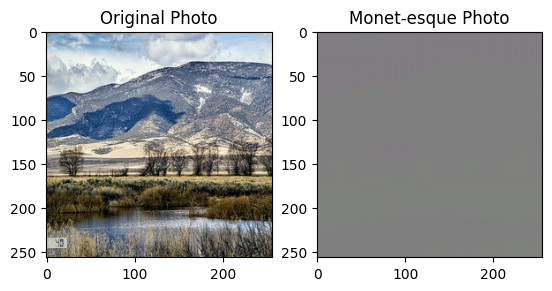

In [22]:
to_monet = monet_generator(example_photo)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

# Build the CycleGAN

This is a TensorFlow 2.x implementation of a CycleGAN model, which includes two generators and two discriminators. The generators, named monet_generator and photo_generator, transform real photos into Monet-style paintings and vice versa. During training, they produce fake images to train the discriminators.

The discriminators, named monet_discriminator and photo_discriminator, identify real and fake images. They distinguish between genuine and fake Monet-style paintings or photos. They help calculate discriminator loss, which measures their ability to differentiate real from fake images, and the generators are trained to minimize the generator loss.

The code utilizes tf.GradientTape() to record tensor operations in the forward pass and compute gradients in the backward pass. The generator and discriminator losses are calculated using the discriminators' outputs on the fake and real images respectively.

The train_step() method calculates losses for the generators and discriminators. Generator losses are based on the discriminator's output for fake images and include cycle consistency losses and same-style losses, reflecting the difference between original and reconstructed or same-style images. The total generator loss is the sum of all these losses, scaled by hyperparameters lambda_cycle and lambda_same_style. Discriminator losses consider both real and fake images.

The cycle consistency loss ensures the generator and its inverse bring the input close to the original. The identity loss prevents the generator from collapsing to a single point, helping to retain some aspects of the input image.

In [23]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

# Loss Function

In the context of a CycleGAN model, a loss function measures how well the model is performing. It is composed of two parts: generator loss and discriminator loss. The generator loss assesses the model's ability to create realistic images that fool the discriminators. The discriminator loss measures how accurately the discriminators differentiate between real and fake images. Additionally, CycleGAN introduces two more losses - cycle consistency loss and identity loss - ensuring the model preserves key image characteristics and retains the input's integrity through the transformations.

In [24]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

In [25]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [29]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [26]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

# Train the CycleGAN

In [27]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [30]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

I would also increase the number of training epochs to 30 since we have already added kernels to prevent overfitting.

In [31]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=30
)

Epoch 1/30


2023-07-11 15:28:23.981952: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-07-11 15:28:25.654610: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


300/300 [==============================] - 182s 160ms/step - monet_gen_loss: 5.2886 - photo_gen_loss: 5.4053 - monet_disc_loss: 0.6841 - photo_disc_loss: 0.6724
Epoch 2/30
300/300 [==============================] - 48s 160ms/step - monet_gen_loss: 3.5625 - photo_gen_loss: 3.6532 - monet_disc_loss: 0.6761 - photo_disc_loss: 0.6613
Epoch 3/30
300/300 [==============================] - 48s 160ms/step - monet_gen_loss: 3.4320 - photo_gen_loss: 3.5052 - monet_disc_loss: 0.6657 - photo_disc_loss: 0.6581
Epoch 4/30
300/300 [==============================] - 48s 160ms/step - monet_gen_loss: 3.3959 - photo_gen_loss: 3.4390 - monet_disc_loss: 0.6412 - photo_disc_loss: 0.6451
Epoch 5/30
300/300 [==============================] - 48s 160ms/step - monet_gen_loss: 3.2988 - photo_gen_loss: 3.3190 - monet_disc_loss: 0.6254 - photo_disc_loss: 0.6329
Epoch 6/30
300/300 [==============================] - 48s 160ms/step - monet_gen_loss: 3.2286 - photo_gen_loss: 3.2301 - monet_disc_loss: 0.6099 - photo_di

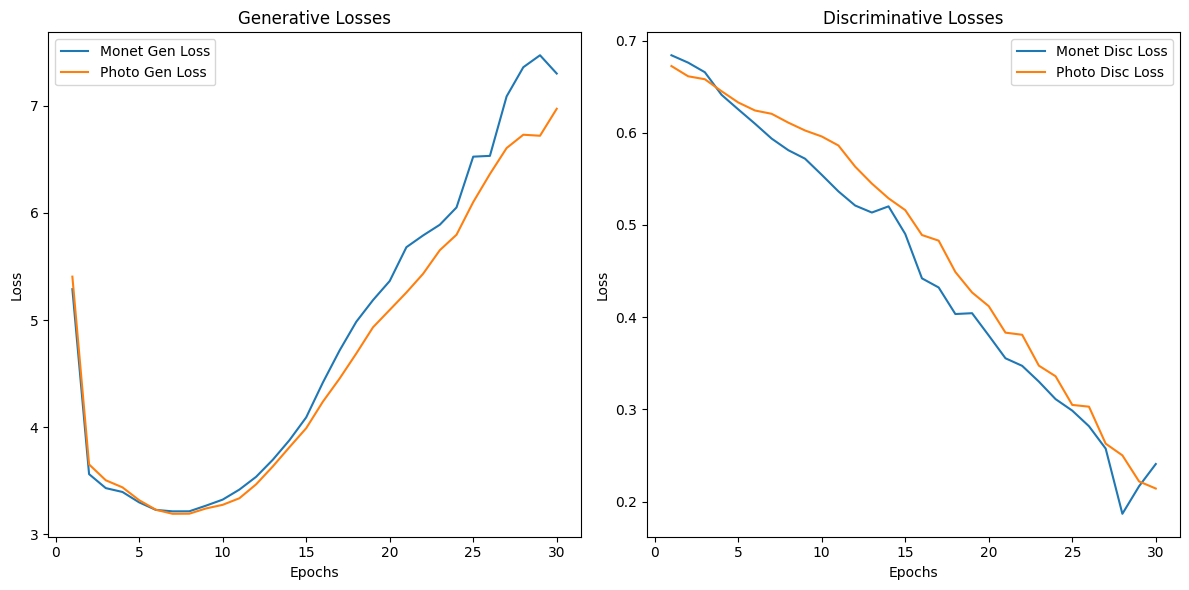

In [35]:
# Epochs
epochs = list(range(1, 31))

# Generative losses
monet_gen_losses = [5.2886, 3.5625, 3.4320, 3.3959, 3.2988, 3.2286, 3.2152, 3.2156, 3.2683, 3.3246, 3.4182, 3.5372, 3.6964, 3.8797, 4.0921, 4.4177, 4.7165, 4.9845, 5.1864, 5.3645, 5.6802, 5.7899, 5.8896, 6.0510, 6.5250, 6.5323, 7.0874, 7.3596, 7.4712, 7.3006]
photo_gen_losses = [5.4053, 3.6532, 3.5052, 3.4390, 3.3190, 3.2301, 3.1923, 3.1932, 3.2421, 3.2760, 3.3374, 3.4670, 3.6341, 3.8143, 3.9909, 4.2389, 4.4544, 4.6883, 4.9326, 5.0948, 5.2574, 5.4321, 5.6520, 5.7963, 6.1009, 6.3631, 6.6053, 6.7296, 6.7201, 6.9718]

# Discriminative losses
monet_disc_losses = [0.6841, 0.6761, 0.6657, 0.6412, 0.6254, 0.6099, 0.5937, 0.5811, 0.5719, 0.5544, 0.5364, 0.5211, 0.5135, 0.5202, 0.4902, 0.4421, 0.4322, 0.4034, 0.4043, 0.3801, 0.3554, 0.3472, 0.3301, 0.3111, 0.2986, 0.2817, 0.2574, 0.1867, 0.2166, 0.2407]
photo_disc_losses = [0.6724, 0.6613, 0.6581, 0.6451, 0.6329, 0.6242, 0.6206, 0.6110, 0.6025, 0.5960, 0.5862, 0.5633, 0.5449, 0.5289, 0.5161, 0.4891, 0.4830, 0.4490, 0.4268, 0.4119, 0.3832, 0.3809, 0.3474, 0.3359, 0.3048, 0.3029, 0.2628, 0.2501, 0.2218, 0.2141]

# Plotting generative losses
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, monet_gen_losses, label='Monet Gen Loss')
plt.plot(epochs, photo_gen_losses, label='Photo Gen Loss')
plt.title('Generative Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting discriminative losses
plt.subplot(1, 2, 2)
plt.plot(epochs, monet_disc_losses, label='Monet Disc Loss')
plt.plot(epochs, photo_disc_losses, label='Photo Disc Loss')
plt.title('Discriminative Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

The left plot shows the generator losses, while the right plot shows the discriminator losses. In both plots, the blue line represents Monet images and the orange line represents photo images.

From the generative losses plot, we can see that the generator loss initially decreases, then increases as the number of epochs goes up. This indicates that the generator is initially getting better at creating "realistic" images, but starts to struggle as the number of epochs increases.

From the discriminative losses plot, we can see that the discriminator loss decreases as the number of epochs increases, which means the discriminator is getting better at distinguishing between real and fake images.

# Visualize our Monet-styled Photos

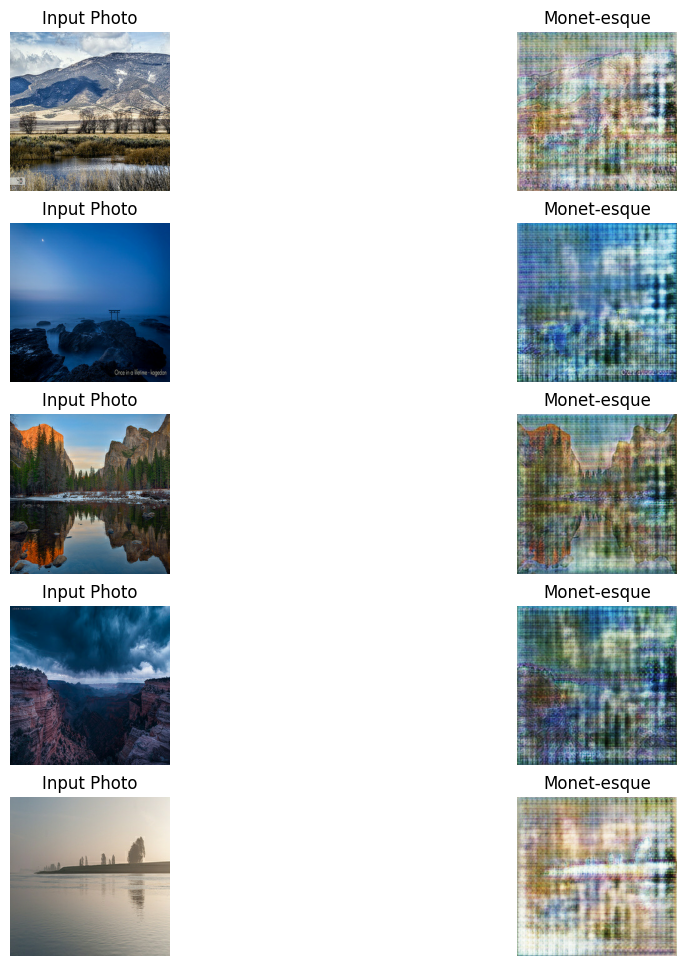

In [32]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

# File Submission

In [33]:
import PIL
! mkdir ../images

In [34]:
i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

In [35]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'

# Result

FID (Fréchet Inception Distance) is a metric used to assess the quality of images generated by GANs (Generative Adversarial Networks). It uses the Inception network to extract features from images and then calculates the Fréchet distance between two Gaussians fitted to these features. A smaller FID suggests the generated images are closer to the real ones.

MiFID (Memorization-informed FID) modifies the FID by including a memorization distance that considers the minimum cosine distance of all training samples in the feature space. A smaller MiFID, like FID, indicates better quality of generated images.

Our MiFID Score is 149.9629 which is pretty high compared to others in the leaderboard. This show that our photo translations are very different from the Monet paintings. This is in agreement with the Generative Loss plot with the loss level increased dramatically after epoch 7. 

Further hyperparameters tunning should find ways to lower the score. One should modify the configuration of the downside, upside as well as the generator and discriminator.